# 📊 FX Qual Engine — Full Analytics Notebook (API + Prometheus + Real-Time Charts + Load Testing + Export)
Includes:
- API invocation
- Prometheus scraping
- Workflow visualizations
- Real-time charts
- Load testing suite
- CSV export + reporting


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import re
import time
import csv
import os

BASE_URL = 'http://localhost:8080'


## 🔹 API Invocation Helper

In [2]:
def qualify_fx(client_type='rest_client', amount=1000000):
    url = f"{BASE_URL}/api/fx/qualify?clientType={client_type}"
    payload = {
        'customerId': 'CUST001',
        'fromCurrency': 'USD',
        'toCurrency': 'EUR',
        'quantity': amount,
        'promoCodes': ['FX50'],
        'productCodes': ['FXSPOT']
    }
    resp = requests.post(url, json=payload)
    return resp.json(), resp.status_code


## 🔹 Prometheus Scraper + Flexible Metric Extractor

In [3]:
def fetch_prometheus():
    return requests.get(f'{BASE_URL}/actuator/prometheus').text

def find_metrics(raw, key):
    return [line for line in raw.split('\n') if key in line]


## 🔹 Metric Parsing → DataFrames (supports _seconds_sum, _count, etc.)

In [4]:
def parse_workflow(lines):
    data = []
    for l in lines:
        # Only consider _count metrics
        if '_count' not in l:
            continue
        value = float(l.split()[-1])
        client = re.search(r'clientImpl="([^"]+)"', l)
        c = client.group(1) if client else 'unknown'
        data.append({'clientImpl': c, 'count': value})
    return pd.DataFrame(data)

def parse_steps(lines):
    data = []
    for l in lines:
        m = re.search(r'step="([^"]+)".* ([0-9\.eE+-]+)$', l)
        if m:
            data.append({'step': m.group(1), 'value': float(m.group(2))})
    return pd.DataFrame(data)


# 🔥 Real-Time Workflow Count Chart

In [5]:
def animate_workflow(i):
    raw = fetch_prometheus()
    wf = find_metrics(raw, 'fxqual_workflow_duration')
    df = parse_workflow(wf)
    plt.cla()
    if not df.empty:
        plt.plot(df['count'], marker='o')
    plt.title('Real-Time Workflow Execution Count')
    plt.grid(True)

fig = plt.figure(figsize=(10,4))
ani = animation.FuncAnimation(fig, animate_workflow, interval=2000)
plt.show()

/var/folders/hy/xswqc07s3517h7mybfn63dqw0000gn/T/ipykernel_14697/4292028172.py:12: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, animate_workflow, interval=2000)


<Figure size 1000x400 with 0 Axes>

# 📊 Step-Level Latency Chart

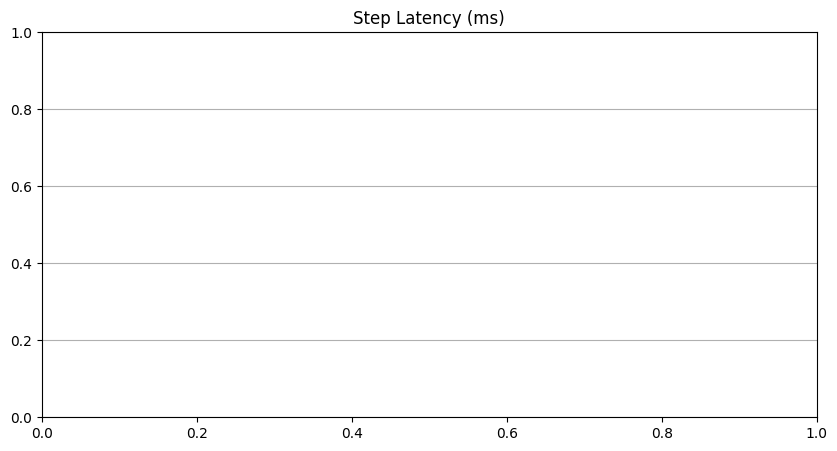

In [6]:
raw = fetch_prometheus()
steps_raw = find_metrics(raw, 'fxqual_step_duration')
steps_df = parse_steps(steps_raw)
plt.figure(figsize=(10,5))
if not steps_df.empty:
    plt.bar(steps_df['step'], steps_df['value'])
plt.title('Step Latency (ms)')
plt.grid(True, axis='y')
plt.show()


# 🚀 Load Testing Suite

In [7]:
def load_test(n=20, client_type='rest_client'):
    for i in range(n):
        qualify_fx(client_type)
        time.sleep(0.1)
    return 'Load test complete'

load_test(5, 'rest_client')


'Load test complete'

# 📦 Export Metrics to CSV

In [8]:
raw = fetch_prometheus()
workflow_df = parse_workflow(find_metrics(raw, 'fxqual_workflow_duration'))
steps_df = parse_steps(find_metrics(raw, 'fxqual_step_duration'))

os.makedirs('exports', exist_ok=True)
workflow_df.to_csv('exports/workflow_metrics.csv', index=False)
steps_df.to_csv('exports/step_metrics.csv', index=False)
workflow_df, steps_df


(             clientImpl  count
 0  FxQualRestClientImpl    5.0,
           step     value
 0     customer  5.000000
 1     customer  0.294226
 2   fxInterest  5.000000
 3   fxInterest  0.000016
 4      product  5.000000
 5      product  0.000026
 6        promo  5.000000
 7        promo  0.000023
 8     customer  0.261496
 9   fxInterest  0.000011
 10     product  0.000022
 11       promo  0.000017)

In [9]:
resp, status = qualify_fx("rest_client")
print(status)
print(resp)

200
{'threadName': None, 'clientType': 'rest_client', 'startTime': 1765053910124, 'endTime': 1765053910161, 'timeTaken': 37, 'execStartDateTime': '2025-12-06T20:45:10.124+00:00', 'execEndDateTime': '2025-12-06T20:45:10.161+00:00', 'ctxData': {'CustomerApiResp': {'customerId': 'CUST001', 'customerName': 'Customer CUST001', 'customerEmail': 'CUST001@example.com', 'customerStatus': 'ACTIVE'}, 'PromoApiResp': {'validPromoCodes': None, 'invalidPromoCodes': None}, 'ProductApiResp': {'validBookCodes': None, 'invalidBookCodes': None}, 'FxInterestApiResp': {'currencyInterestInfos': None}}, 'integrationsCallInfo': []}
